In [1]:
import jax.numpy as jnp
import flax
from flax import struct
from typing import Callable
from jax import random
import kernels
import distributions

/Users/danieltait/anaconda3/envs/flax_fork/lib/python3.7/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [12]:
index_points = jnp.linspace(0., 6., 10)[:, None]
base_kernel_fun = lambda x, y: kernels.rbf_kernel_fun(x, y, 1., 1.)
base_mean_fun = lambda x: jnp.zeros(x.shape[:-1])

In [13]:
gp = distributions.GaussianProcess(index_points, base_mean_fun, base_kernel_fun, 1e-4)

pf_x = gp.marginal()

In [31]:
# generate some data
obs_noise_scale = 0.1

key = random.PRNGKey(0)
f = pf_x.sample(key)
y = f + obs_noise_scale*random.normal(key, (10, ))

xnew = jnp.linspace(0.1, 10., 35)[:, None]

post_gp = gp.posterior_gp(y, xnew, obs_noise_scale**2)

In [32]:
m = post_gp.mean_function(xnew)
kxnew = post_gp.kernel_function(xnew, xnew)
sd = jnp.sqrt(jnp.diag(kxnew))

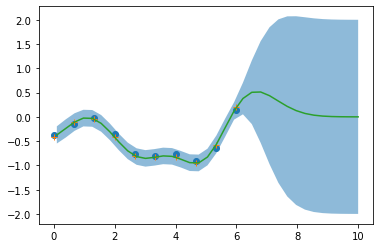

In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(index_points[:, 0], f, 'o')
ax.plot(index_points[:, 0], y, '+')
ax.plot(xnew[:, 0], post_gp.mean_function(xnew))
ax.fill_between(xnew[:, 0], m + 2*sd, m - 2*sd, alpha=0.5)
plt.show()